# Accessing Data

In [1]:
#This gets us into the right directory from home, in order to run the import python script from Mat

#sys = system (module), gives information and control over python interpreter/terminal itself
import sys
sys.path.append("/home/565/pv3484/aus_substation_electricity")

#% is a magic command, special shortcut command that lets you control/interact with notebook environment (ie. gives control of terminal without writing full python code)
%cd aus_substation_electricity/

!pwd

/home/565/pv3484/aus_substation_electricity
/home/565/pv3484/aus_substation_electricity


In [2]:
#This section imports the substations that Mat put together

%run /home/565/pv3484/aus_substation_electricity/import_substation.py

processing nsw substations for ['ausgrid'] from None to None
ausgrid
following columns in demand are not in info index:
['MT_HU', 'SI_NO']
removing these columns from demand
number of substations in ausgrid substation info: 134
number of substations in ausgrid substation data: 132
following sites match selection criteria:
               energy_asset          Name  Area  Dwellings  Persons  Residential  Commercial  Industrial  Primary Production  Education  \
ID                                                                                                                                        
BLAKE         AG_BLAKEHURST    Blakehurst     7      10081    28521        0.850       0.005       0.021               0.000      0.022   
PUNCH          AG_PUNCHBOWL     Punchbowl     9      17514    50395        0.826       0.048       0.038               0.000      0.025   
MEADO         AG_MEADOWBANK    Meadowbank    15      22420    56948        0.825       0.023       0.015               0

# Demand Anonmaly Public Holiday only
- plotting 30 days +/- around public holidays
- baseline 2 year period
- shows when demand peaks

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil.easter import easter

def compare_holiday_only_window(demand, info, station, years, holiday_func, holiday_name):
    """
    Plot demand anomalies for a holiday (24-hour profile),
    using the ±30-day window around the holiday as baseline.
    """
    
    demand.index = pd.to_datetime(demand.index)
    hourly = demand[[station]].resample("h").mean()
    
    # Collect ±30-day windows around the holiday
    windows = []
    for year in years:
        ref_date = holiday_func(year)
        start = ref_date - pd.Timedelta(days=30)
        end   = ref_date + pd.Timedelta(days=30)
        window = hourly.loc[start:end].copy()
        window["mdh"] = window.index.strftime("%m-%d %H:%M")
        window = window.set_index("mdh")
        windows.append(window)
    
    combined = pd.concat(windows, axis=1)
    baseline_mean = combined.mean(axis=1).mean()
    anomalies = combined.subtract(baseline_mean, axis=0)
    avg_anomaly = anomalies.mean(axis=1)
    
    # Holiday anomalies (24 hours)
    holiday_hours = []
    for year in years:
        ref_date = holiday_func(year)
        day_str = ref_date.strftime("%m-%d")
        daily = avg_anomaly.loc[avg_anomaly.index.str.startswith(day_str)]
        daily.index = range(24)
        holiday_hours.append(daily)
    holiday_profile = pd.concat(holiday_hours, axis=1).mean(axis=1)
    
    # --- Plot ---
    plt.figure(figsize=(12,5))
    plt.plot(holiday_profile.index, holiday_profile.values, color="red", linewidth=2, marker="o",
             label=f"{holiday_name} (±30-Day Window)")
    
    plt.axhline(0, color="black", linewidth=1)
    plt.grid(axis='y', linestyle='-', linewidth=0.5, color='gray', alpha=0.3)
    plt.xticks(np.arange(0, 24, 1), [f"{h:02d}:00" for h in range(24)], rotation=45)
    
    full_name = info.loc[station, "Name"]
    plt.title(
        f"{full_name} Demand Anomaly: {holiday_name} (±30-Day Window, {years[0]}–{years[-1]})",
        fontsize=14
    )
    plt.xlabel("Hour of Day")
    plt.ylabel("Electricity Demand Anomaly")
    plt.legend()
    plt.tight_layout()
    plt.show()

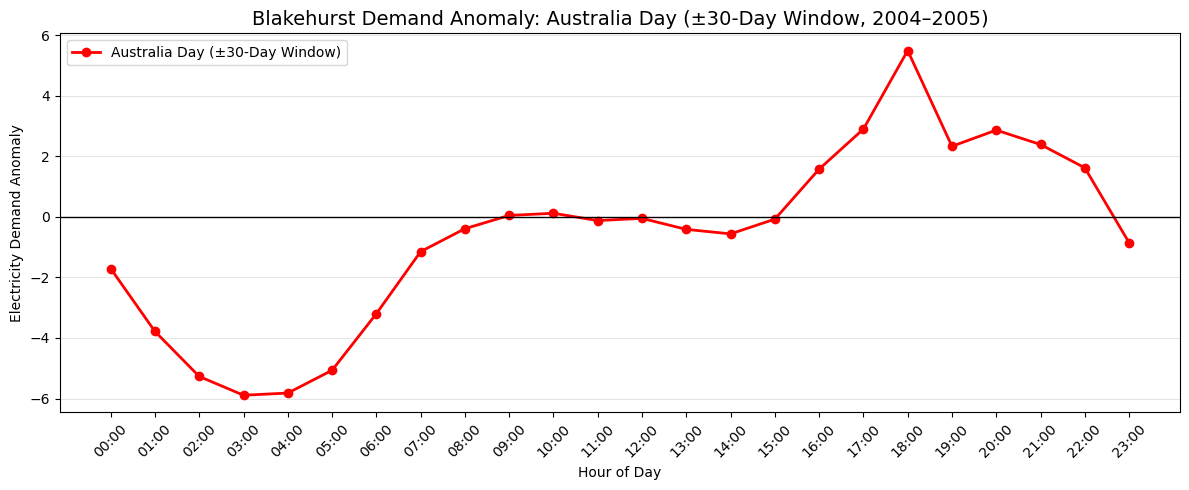

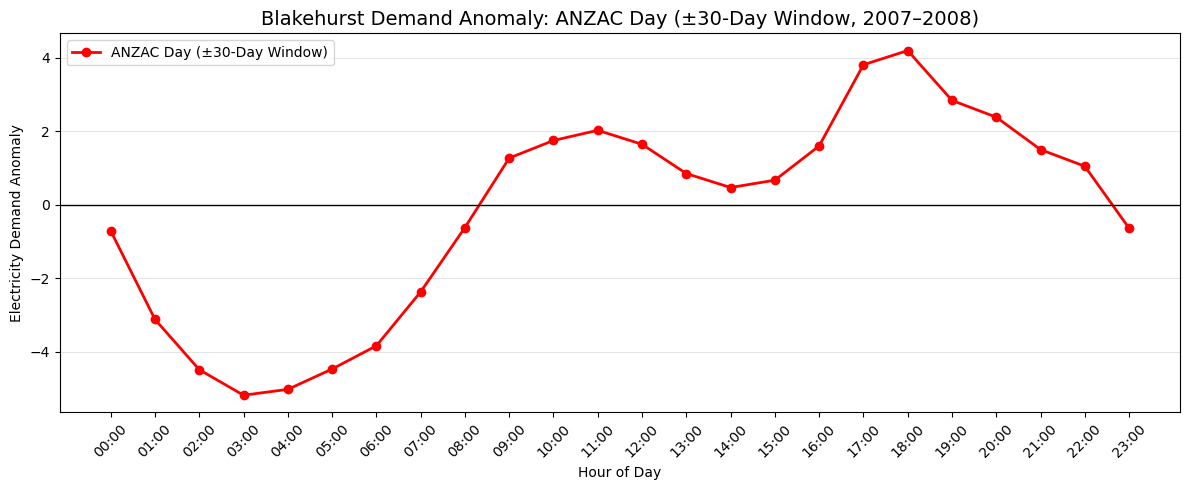

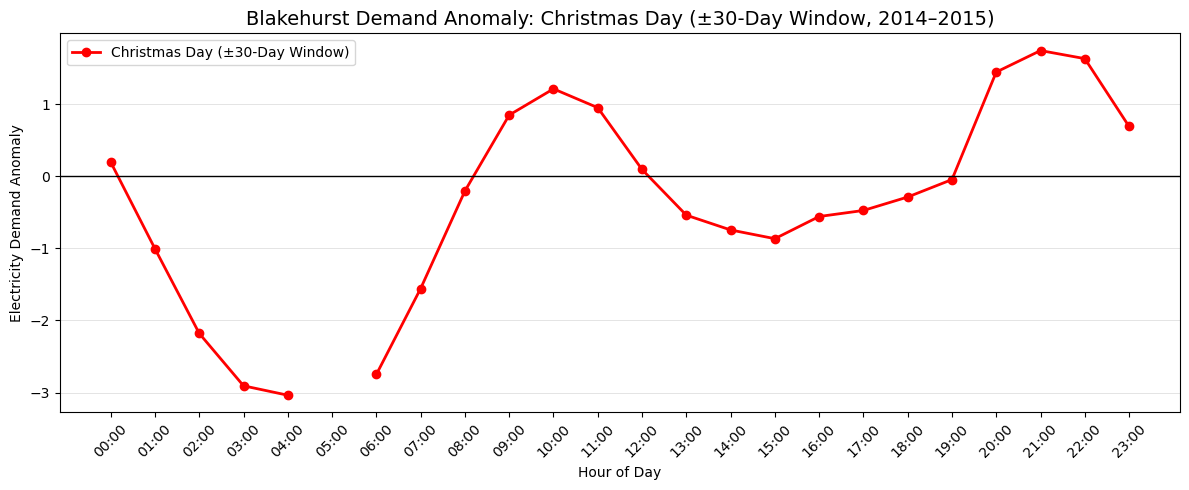

In [4]:
station = "BLAKE"

# Australia Day anomaly only
compare_holiday_only_window(
    demand, info, station, [2004, 2005],
    holiday_func=lambda y: pd.Timestamp(f"{y}-01-26"),
    holiday_name="Australia Day"
)

# ANZAC Day anomaly only
compare_holiday_only_window(
    demand, info, station, [2007, 2008],
    holiday_func=lambda y: pd.Timestamp(f"{y}-04-25"),
    holiday_name="ANZAC Day"
)

# Christmas anomaly only
compare_holiday_only_window(
    demand, info, station, [2014, 2015],
    holiday_func=lambda y: pd.Timestamp(f"{y}-12-25"),
    holiday_name="Christmas Day"
)